In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ddm import Model, Sample
from ddm import Model
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICRange
from ddm.functions import fit_adjust_model, display_model
from ddm import Fittable
from ddm.models import LossRobustBIC, LossRobustLikelihood, LossSquaredError
from ddm.functions import fit_adjust_model, fit_model
import seaborn as sns

In [2]:
from ddm import set_N_cpus
set_N_cpus(8)

In [ ]:
model_fits = np.zeros((14, 12, 4), dtype = object)
incorrect_thresold = np.array([np.pi/9])
for participant in range(14):
    noise_fittable=Fittable(minval = 0, maxval = 10)
    ter_fittable=Fittable(minval=0, maxval=5)
    for block in range(12):
        for ic in range(len(incorrect_thresold)):
            df_rt = pd.read_csv(open('RTs.csv'))
            df_error = pd.read_csv(open('Angular_errors.csv'))

            df_rt['Correct'] = 0
            df_rt['Correct'][df_error['Error'] < incorrect_thresold[ic]] = 1
            df_rt['Correct'][df_error['Error'] > incorrect_thresold[ic]] = 0

            df_rt = df_rt[df_rt['participant_id'] == participant]

            df_rt = df_rt[df_rt["ITs"] > .001]
            df_rt = df_rt[df_rt["ITs"] < 5]
            df_rt = df_rt.drop(['Trial', 'Unnamed: 0', 'participant_id', 'condition', 'MTs'], axis = 1)

            samp = Sample.from_pandas_dataframe(df_rt[df_rt['block'] == block], rt_column_name="ITs", correct_column_name="Correct")
            if block > 1:
                model_fit = Model(name='Simple model (fitted)',
                              drift=DriftConstant(drift=Fittable(minval=-100, maxval=200)),
                              noise=NoiseConstant(noise=model_fits[participant][1][ic].get_model_parameters()[1].real),                      
                              bound=BoundConstant(B=Fittable(minval = 0, maxval = 200)),
                              overlay=OverlayNonDecision(nondectime=model_fits[participant][1][ic].get_model_parameters()[3].real),
                              dx=.001, dt=.01, T_dur=5)
            else:
                model_fit = Model(name='Simple model (fitted)',
                              drift=DriftConstant(drift=Fittable(minval=-10, maxval=10)),
                              noise=NoiseConstant(noise=Fittable(minval = 0, maxval = 10)),                      
                              bound=BoundConstant(B=Fittable(minval = 0, maxval = 10)),
                              overlay=OverlayNonDecision(nondectime=Fittable(minval = 0, maxval = 1)),
                              dx=.001, dt=.01, T_dur=5)

            #try:
            fit_adjust_model(samp, model_fit,
                             fitting_method="differential_evolution",
                             lossfunction=LossRobustLikelihood, verbose=False)
            #except:
            #    print (participant, block)
            model_fits[participant][block][ic] = model_fit

In [ ]:
model_fits[participant][block][0]

In [ ]:
drift_rates = np.zeros((14, 12, len(incorrect_thresold)))
drift_noise = np.zeros((14, 12, len(incorrect_thresold)))
bounds = np.zeros((14, 12, len(incorrect_thresold)))
Ter = np.zeros((14, 12, len(incorrect_thresold)))
for participant in range(14):
    for block in range(12):
        for ic in range(len(incorrect_thresold)):
            if block > 1:
                drift_rates[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[0].real
                #drift_noise[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[1].real
                drift_noise[participant][block][ic] = model_fits[participant][1][ic].get_model_parameters()[1].real

                bounds[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[1].real 
                #Ter[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[3].real
                Ter[participant][block][ic] = model_fits[participant][1][ic].get_model_parameters()[3].real
            else:
                drift_rates[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[0].real
                drift_noise[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[1].real
                #drift_noise[participant][block][ic] = model_fits[participant][1][ic].get_model_parameters()[1].real

                bounds[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[2].real 
                Ter[participant][block][ic] = model_fits[participant][block][ic].get_model_parameters()[3].real
                #Ter[participant][block][ic] = model_fits[participant][1][ic].get_model_parameters()[3].real
                

In [ ]:
df_ddm = pd.DataFrame({'Condition': np.tile(np.ravel(np.array([np.repeat(['Sudden'], 12*len(incorrect_thresold)), np.repeat(['Gradual'], 12*len(incorrect_thresold))])), 7),
                       'Block': np.tile(np.repeat(np.arange(12), len(incorrect_thresold)), 14),
                      'Drift_Rates': np.ravel(drift_rates),
                       'Drift_Noise': np.ravel(drift_noise),
                       'Incorrect_Criterian':np.tile(np.array([20]), 12*14),
                      'Bounds': np.ravel(bounds),
                      'Ter': np.ravel(Ter)})

In [ ]:
df_ddm

In [ ]:
sns.catplot(x = 'Block', y = 'Bounds', data = df_ddm, kind='point', hue = 'Condition', ci = 95, col = 'Incorrect_Criterian', capsize = 0.2)

In [47]:
from ddm import Bound
class BoundBlocks(Bound):
    name = "constant"
    required_parameters = ["BBlock0", "BBlock1", "BBlock2", "BBlock3", "BBlock4", "BBlock5",
                          "BBlock6", "BBlock7", "BBlock8", "BBlock9", "BBlock10", "BBlock11"]
    required_conditions = ['block']
    def get_bound(self, conditions, *args, **kwargs):
        if conditions['block'] == 0:
            return self.BBlock0
        if conditions['block'] == 1:
            return self.BBlock1
        if conditions['block'] == 2:
            return self.BBlock2
        if conditions['block'] == 3:
            return self.BBlock3
        if conditions['block'] == 4:
            return self.BBlock4
        if conditions['block'] == 5:
            return self.BBlock5
        if conditions['block'] == 6:
            return self.BBlock6
        if conditions['block'] == 7:
            return self.BBlock7
        if conditions['block'] == 8:
            return self.BBlock8
        if conditions['block'] == 9:
            return self.BBlock9
        if conditions['block'] == 10:
            return self.BBlock10
        if conditions['block'] == 11:
            return self.BBlock11

In [48]:
from ddm import Drift
class DriftBlocks(Drift):
    name = "constant"
    required_parameters = ["VBlock0", "VBlock1", "VBlock2", "VBlock3", "VBlock4", "VBlock5",
                          "VBlock6", "VBlock7", "VBlock8", "VBlock9", "VBlock10", "VBlock11"]
    required_conditions = ['block']
    def get_drift(self, conditions, *args, **kwargs):
        if conditions['block'] == 0:
            return self.VBlock0
        if conditions['block'] == 1:
            return self.VBlock1
        if conditions['block'] == 2:
            return self.VBlock2
        if conditions['block'] == 3:
            return self.VBlock3
        if conditions['block'] == 4:
            return self.VBlock4
        if conditions['block'] == 5:
            return self.VBlock5
        if conditions['block'] == 6:
            return self.VBlock6
        if conditions['block'] == 7:
            return self.VBlock7
        if conditions['block'] == 8:
            return self.VBlock8
        if conditions['block'] == 9:
            return self.VBlock9
        if conditions['block'] == 10:
            return self.VBlock10
        if conditions['block'] == 11:
            return self.VBlock11

In [65]:
model_fits = np.zeros(14, dtype = object)
for participant in range(14):
    print(participant)
    df_rt = pd.read_csv(open('RTs.csv'))
    df_error = pd.read_csv(open('Angular_errors.csv'))

    df_rt['Correct'] = 0
    df_rt['Correct'][df_error['Error'] < np.pi/9] = 1
    df_rt['Correct'][df_error['Error'] > np.pi/9] = 0

    df_rt = df_rt[df_rt['participant_id'] == participant]

    df_rt = df_rt[df_rt["ITs"] > .001]
    df_rt = df_rt[df_rt["ITs"] < 5]
    df_rt = df_rt.drop(['Trial', 'Unnamed: 0', 'participant_id', 'condition', 'MTs'], axis = 1)

    samp = Sample.from_pandas_dataframe(df_rt, rt_column_name="ITs", correct_column_name="Correct")
    
    model_fits[participant] = fit_model(samp, bound=BoundBlocks(BBlock0 = Fittable(minval = 0, maxval = 20),
                               BBlock1 = Fittable(minval = 0, maxval = 20),
                               BBlock2 = Fittable(minval = 0, maxval = 20),
                               BBlock3 = Fittable(minval = 0, maxval = 20),
                               BBlock4 = Fittable(minval = 0, maxval = 20),
                               BBlock5 = Fittable(minval = 0, maxval = 20),
                               BBlock6 = Fittable(minval = 0, maxval = 20),
                               BBlock7 = Fittable(minval = 0, maxval = 20),
                               BBlock8 = Fittable(minval = 0, maxval = 20),
                               BBlock9 = Fittable(minval = 0, maxval = 20),
                               BBlock10 = Fittable(minval = 0, maxval = 20),
                               BBlock11 = Fittable(minval = 0, maxval = 20)),
              
              drift=DriftBlocks(VBlock0 = Fittable(minval = -20, maxval = 20),
                               VBlock1 = Fittable(minval = -20, maxval = 20),
                               VBlock2 = Fittable(minval = -20, maxval = 20),
                               VBlock3 = Fittable(minval = -20, maxval = 20),
                               VBlock4 = Fittable(minval = -20, maxval = 20),
                               VBlock5 = Fittable(minval = -20, maxval = 20),
                               VBlock6 = Fittable(minval = -20, maxval = 20),
                               VBlock7 = Fittable(minval = -20, maxval = 20),
                               VBlock8 = Fittable(minval = -20, maxval = 20),
                               VBlock9 = Fittable(minval = -20, maxval = 20),
                               VBlock10 = Fittable(minval = -20, maxval = 20),
                               VBlock11 = Fittable(minval = -20, maxval = 20)),
              
              overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=0.5)),
              
              noise=NoiseConstant(noise=Fittable(minval=0.01, maxval=5)), 
              lossfunction=LossRobustLikelihood, verbose = False
             )

0


<ipython-input-65-c07f6662b8fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] < np.pi/9] = 1
<ipython-input-65-c07f6662b8fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] > np.pi/9] = 0


differential_evolution step 1: f(x)= 3293.48
differential_evolution step 2: f(x)= 3221.94
differential_evolution step 3: f(x)= 2628.8
differential_evolution step 4: f(x)= 2628.8
differential_evolution step 5: f(x)= 2628.8
differential_evolution step 6: f(x)= 2356.39
differential_evolution step 7: f(x)= 2233.13
differential_evolution step 8: f(x)= 2233.13
differential_evolution step 9: f(x)= 2233.13
differential_evolution step 10: f(x)= 2233.13
differential_evolution step 11: f(x)= 2233.13
differential_evolution step 12: f(x)= 2233.13
differential_evolution step 13: f(x)= 1861.49
differential_evolution step 14: f(x)= 1861.49
differential_evolution step 15: f(x)= 1501.59
differential_evolution step 16: f(x)= 1501.59
differential_evolution step 17: f(x)= 1501.59
differential_evolution step 18: f(x)= 1501.59
differential_evolution step 19: f(x)= 1501.59
differential_evolution step 20: f(x)= 1501.59
differential_evolution step 21: f(x)= 1501.59
differential_evolution step 22: f(x)= 1423
dif

<ipython-input-65-c07f6662b8fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] < np.pi/9] = 1
<ipython-input-65-c07f6662b8fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] > np.pi/9] = 0


differential_evolution step 1: f(x)= 2444.82
differential_evolution step 2: f(x)= 2404.61
differential_evolution step 3: f(x)= 2062.04
differential_evolution step 4: f(x)= 2062.04
differential_evolution step 5: f(x)= 2025.25
differential_evolution step 6: f(x)= 1524.46
differential_evolution step 7: f(x)= 1509.11
differential_evolution step 8: f(x)= 1509.11
differential_evolution step 9: f(x)= 1509.11
differential_evolution step 10: f(x)= 1384.3
differential_evolution step 11: f(x)= 1384.3
differential_evolution step 12: f(x)= 1328.21
differential_evolution step 13: f(x)= 1328.21
differential_evolution step 14: f(x)= 1328.21
differential_evolution step 15: f(x)= 1234.18
differential_evolution step 16: f(x)= 1193.46
differential_evolution step 17: f(x)= 1155.84
differential_evolution step 18: f(x)= 1153.39
differential_evolution step 19: f(x)= 1153.39
differential_evolution step 20: f(x)= 1151.91
differential_evolution step 21: f(x)= 1151.91
differential_evolution step 22: f(x)= 1094.89

<ipython-input-65-c07f6662b8fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] < np.pi/9] = 1
<ipython-input-65-c07f6662b8fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] > np.pi/9] = 0


differential_evolution step 1: f(x)= 1218.18
differential_evolution step 2: f(x)= 1218.18
differential_evolution step 3: f(x)= 1189.52
differential_evolution step 4: f(x)= 1189.52
differential_evolution step 5: f(x)= 925.552
differential_evolution step 6: f(x)= 925.552
differential_evolution step 7: f(x)= 814.141
differential_evolution step 8: f(x)= 814.141
differential_evolution step 9: f(x)= 814.141
differential_evolution step 10: f(x)= 528.087
differential_evolution step 11: f(x)= 528.087
differential_evolution step 12: f(x)= 528.087
differential_evolution step 13: f(x)= 528.087
differential_evolution step 14: f(x)= 528.087
differential_evolution step 15: f(x)= 499.617
differential_evolution step 16: f(x)= 499.617
differential_evolution step 17: f(x)= 499.617
differential_evolution step 18: f(x)= 499.617
differential_evolution step 19: f(x)= 499.617
differential_evolution step 20: f(x)= 368.016
differential_evolution step 21: f(x)= 368.016
differential_evolution step 22: f(x)= 368.0

<ipython-input-65-c07f6662b8fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] < np.pi/9] = 1
<ipython-input-65-c07f6662b8fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] > np.pi/9] = 0


differential_evolution step 1: f(x)= 3014.58
differential_evolution step 2: f(x)= 2092.97
differential_evolution step 3: f(x)= 2092.97
differential_evolution step 4: f(x)= 2092.97
differential_evolution step 5: f(x)= 2049.28
differential_evolution step 6: f(x)= 1481.57
differential_evolution step 7: f(x)= 1481.57
differential_evolution step 8: f(x)= 1481.57
differential_evolution step 9: f(x)= 1018.71
differential_evolution step 10: f(x)= 1018.71
differential_evolution step 11: f(x)= 1018.71
differential_evolution step 12: f(x)= 862.755
differential_evolution step 13: f(x)= 862.755
differential_evolution step 14: f(x)= 862.755
differential_evolution step 15: f(x)= 862.755
differential_evolution step 16: f(x)= 862.755
differential_evolution step 17: f(x)= 862.755
differential_evolution step 18: f(x)= 862.755
differential_evolution step 19: f(x)= 862.755
differential_evolution step 20: f(x)= 862.755
differential_evolution step 21: f(x)= 862.755
differential_evolution step 22: f(x)= 862.7

<ipython-input-65-c07f6662b8fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] < np.pi/9] = 1
<ipython-input-65-c07f6662b8fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] > np.pi/9] = 0


differential_evolution step 1: f(x)= 2094.52
differential_evolution step 2: f(x)= 1770.36
differential_evolution step 3: f(x)= 1770.36
differential_evolution step 4: f(x)= 1548.06
differential_evolution step 5: f(x)= 1383.69
differential_evolution step 6: f(x)= 1144.26
differential_evolution step 7: f(x)= 1092.21
differential_evolution step 8: f(x)= 1092.21
differential_evolution step 9: f(x)= 1092.21
differential_evolution step 10: f(x)= 1031.48
differential_evolution step 11: f(x)= 1031.48
differential_evolution step 12: f(x)= 1031.48
differential_evolution step 13: f(x)= 1031.48
differential_evolution step 14: f(x)= 931.696
differential_evolution step 15: f(x)= 931.696
differential_evolution step 16: f(x)= 908.355
differential_evolution step 17: f(x)= 908.355
differential_evolution step 18: f(x)= 908.355
differential_evolution step 19: f(x)= 908.355
differential_evolution step 20: f(x)= 908.355
differential_evolution step 21: f(x)= 813.524
differential_evolution step 22: f(x)= 745.2

<ipython-input-65-c07f6662b8fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] < np.pi/9] = 1
<ipython-input-65-c07f6662b8fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['Correct'][df_error['Error'] > np.pi/9] = 0


differential_evolution step 1: f(x)= 2381.84
differential_evolution step 2: f(x)= 2381.84
differential_evolution step 3: f(x)= 1803.16
differential_evolution step 4: f(x)= 1803.16
differential_evolution step 5: f(x)= 1803.16
differential_evolution step 6: f(x)= 1803.16
differential_evolution step 7: f(x)= 1803.16
differential_evolution step 8: f(x)= 1803.16
differential_evolution step 9: f(x)= 1729.14
differential_evolution step 10: f(x)= 1709.74
differential_evolution step 11: f(x)= 1500.02
differential_evolution step 12: f(x)= 1426.04
differential_evolution step 13: f(x)= 1426.04
differential_evolution step 14: f(x)= 1426.04
differential_evolution step 15: f(x)= 1426.04
differential_evolution step 16: f(x)= 1426.04
differential_evolution step 17: f(x)= 1350.16
differential_evolution step 18: f(x)= 1350.16
differential_evolution step 19: f(x)= 1094.75
differential_evolution step 20: f(x)= 1094.75
differential_evolution step 21: f(x)= 1094.75
differential_evolution step 22: f(x)= 1094.

ValueError: zero-size array to reduction operation maximum which has no identity

In [74]:
import pickle
pickle.dump(model_fits, open('ddm_model_point_fits.pickle', 'wb'))

# Using HDDMs

In [2]:
import hddm

C:\Users\Tejas\anaconda3\lib\site-packages\IPython\parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [3]:
df_rt = hddm.load_csv('RTs.csv')

In [4]:
df_rt = df_rt.drop(['Unnamed: 0', 'MTs'], axis = 1)
df_error = pd.read_csv(open('Angular_errors.csv'))

df_rt['response'] = 0
df_rt['response'][df_error['Error'] < np.pi/9] = 1
df_rt['response'][df_error['Error'] > np.pi/9] = 0



<ipython-input-4-f9c3b37dc88a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['response'][df_error['Error'] < np.pi/9] = 1
<ipython-input-4-f9c3b37dc88a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt['response'][df_error['Error'] > np.pi/9] = 0


In [5]:
df_rt = df_rt.rename(columns={'participant_id': 'subj_idx', 'ITs':'rt'})


In [57]:
m = hddm.HDDM(df_rt)


In [58]:
m.find_starting_values()

In [59]:
m.sample(2000, burn = 20)

 [-----------------100%-----------------] 2000 of 2000 complete in 460.4 sec

In [60]:
stats = m.gen_stats()

In [62]:
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.13484,0.194851,1.78852,2.00406,2.12462,2.24595,2.5731,0.00693227
a_std,0.726409,0.183406,0.455013,0.596192,0.694274,0.831464,1.17195,0.00860781
a_subj.0,1.97159,0.0450135,1.88241,1.9412,1.97107,2.00136,2.05996,0.00141201
a_subj.1,2.33866,0.0607831,2.22544,2.29638,2.33684,2.37999,2.46379,0.002478


Plotting a
Plotting a_std
Plotting v
Plotting t


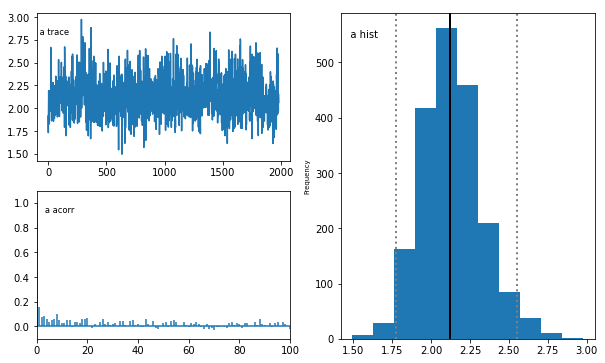

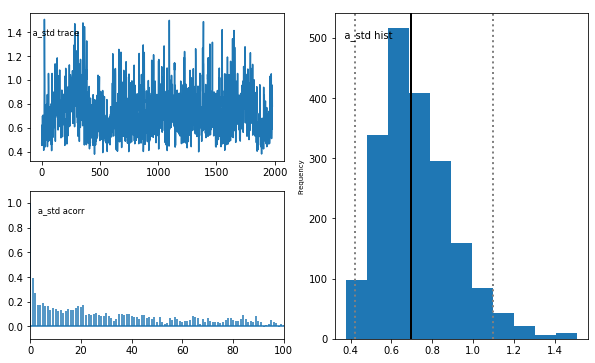

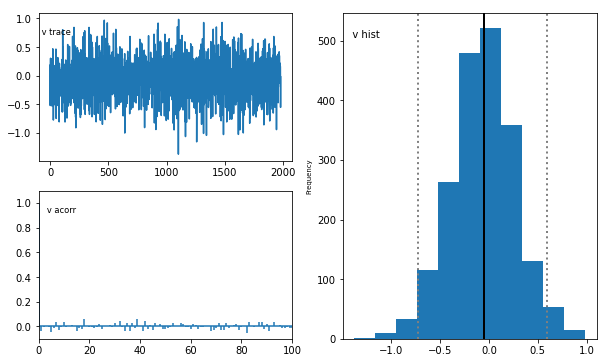

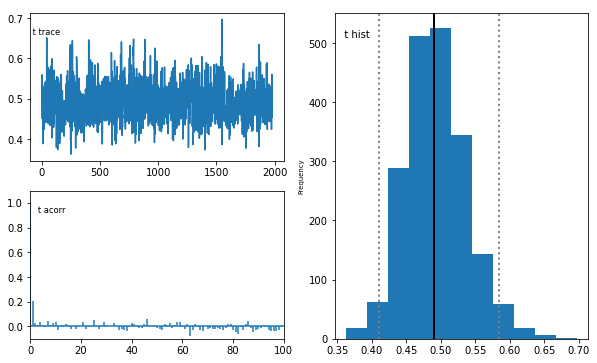

In [63]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])


In [152]:
m_stim = hddm.HDDM(df_rt, depends_on={'v': ['block', 'condition'], 'a':['block', 'condition']})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000, dbname = 'traces.db', db = 'pickle')
m_stim.save('hddm_fit')

non_hierarchical_model = hddm.HDDM(df_rt, depends_on={'v': ['block', 'condition'], 'a':['block', 'condition']}, is_group_model = False)
non_hierarchical_model.find_starting_values()
non_hierarchical_model.sample(10000, burn=1000, dbname = 'traces.db', db = 'pickle')
non_hierarchical_model.save('nhddm_fit')

 [-----------------100%-----------------] 10000 of 10000 complete in 5300.2 sec-17191.38500230904
-17191.321958238004
 [-----------------100%-----------------] 10000 of 10000 complete in 1313.5 sec-------------   38%                  ] 3813 of 10000 complete in 505.2 sec

In [148]:
m_stim.dbname = 'traces.db'
m_stim.db = 'pickle'

In [151]:
m_stim.

,subj_idx,condition,Trial,rt,block,response
0,0,Sudden,0,-0.000074,0,0
1,1,Gradual,0,-0.000075,0,0
2,2,Sudden,0,-0.000134,0,0
3,3,Gradual,0,0.883418,0,1
4,4,Sudden,0,-0.920651,0,0
...,...,...,...,...,...,...
10747,9,Gradual,767,0.780795,11,1
10748,10,Sudden,767,0.733294,11,1
10749,11,Gradual,767,-1.200126,11,0
10750,12,Sudden,767,0.560747,11,1


In [145]:
m_stim.save('hddm_fit')

ValueError: db is 'ram'. Saving a model requires a database on disk.

In [9]:
stats = m_stim.gen_stats()

In [138]:
list(m_stim.nodes_db.node)

[<pymc.distributions.new_dist_class.<locals>.new_class 'a(0.Gradual)' at 0x000002853C1C8940>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(0.Sudden)' at 0x0000028536A58E20>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(1.Gradual)' at 0x000002853C1F90D0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(1.Sudden)' at 0x000002853C1F9100>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(2.Gradual)' at 0x0000028536A4D760>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(2.Sudden)' at 0x000002853C1B6370>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(3.Gradual)' at 0x000002853C1B6190>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(3.Sudden)' at 0x000002853C1B66A0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(4.Gradual)' at 0x000002853C1B6400>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(4.Sudden)' at 0x000002853C1C87C0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a(5.Gradu

In [130]:
v_gradual = m_stim.nodes_db.node[['v(0.Gradual)', 'v(1.Gradual)', 'v(2.Gradual)', 'v(3.Gradual)', 'v(4.Gradual)', 'v(5.Gradual)',
                                'v(6.Gradual)', 'v(7.Gradual)', 'v(8.Gradual)', 'v(9.Gradual)', 'v(10.Gradual)', 'v(11.Gradual)']]

In [131]:
v_sudden = m_stim.nodes_db.node[['v(0.Sudden)', 'v(1.Sudden)', 'v(2.Sudden)', 'v(3.Sudden)', 'v(4.Sudden)', 'v(5.Sudden)',
                                'v(6.Sudden)', 'v(7.Sudden)', 'v(8.Sudden)', 'v(9.Sudden)', 'v(10.Sudden)', 'v(11.Sudden)']]

In [127]:
a_gradual = m_stim.nodes_db.node[['a(0.Gradual)', 'a(1.Gradual)', 'a(2.Gradual)', 'a(3.Gradual)', 'a(4.Gradual)', 'a(5.Gradual)',
                                'a(6.Gradual)', 'a(7.Gradual)', 'a(8.Gradual)', 'a(9.Gradual)', 'a(10.Gradual)', 'a(11.Gradual)']]

In [128]:
a_sudden = m_stim.nodes_db.node[['a(0.Sudden)', 'a(1.Sudden)', 'a(2.Sudden)', 'a(3.Sudden)', 'a(4.Sudden)', 'a(5.Sudden)',
                                'a(6.Sudden)', 'a(7.Sudden)', 'a(8.Sudden)', 'a(9.Sudden)', 'a(10.Sudden)', 'a(11.Sudden)']]

(-4.0, 4.0)

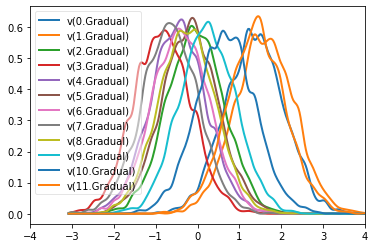

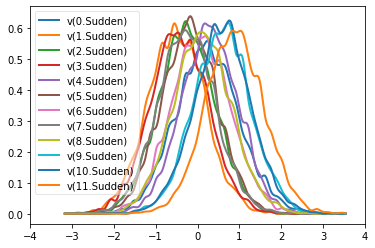

In [136]:
hddm.analyze.plot_posterior_nodes(v_gradual)
plt.xlim((-4, 4))
hddm.analyze.plot_posterior_nodes(v_sudden) 
plt.xlim((-4, 4))


In [36]:
non_hierarchical_model = hddm.HDDM(df_rt, depends_on={'v': ['block', 'condition'], 'a':['block', 'condition']}, is_group_model = False)
non_hierarchical_model.find_starting_values()
non_hierarchical_model.sample(10000, burn=1000)

-17191.336388660362
-17191.31484475386
Halting at iteration  1620  of  10000   ] 1618 of 10000 complete in 217.6 sec


In [140]:
m_stim.sample(5000, dbname = 'traces.db', db = 'pickle')

 [                  0%                  ] 10 of 5000 complete in 6.8 secHalting at iteration  9  of  5000


In [84]:
stats.to_csv('hddm_fits.csv')

In [5]:
s = pd.read_csv('hddm_fits.csv')

In [8]:
list(s['Unnamed: 0'])

['a(0.Gradual)',
 'a(0.Sudden)',
 'a(1.Gradual)',
 'a(1.Sudden)',
 'a(2.Gradual)',
 'a(2.Sudden)',
 'a(3.Gradual)',
 'a(3.Sudden)',
 'a(4.Gradual)',
 'a(4.Sudden)',
 'a(5.Gradual)',
 'a(5.Sudden)',
 'a(6.Gradual)',
 'a(6.Sudden)',
 'a(7.Gradual)',
 'a(7.Sudden)',
 'a(8.Gradual)',
 'a(8.Sudden)',
 'a(9.Gradual)',
 'a(9.Sudden)',
 'a(10.Gradual)',
 'a(10.Sudden)',
 'a(11.Gradual)',
 'a(11.Sudden)',
 'a_std',
 'a_subj(0.Gradual).1',
 'a_subj(0.Gradual).3',
 'a_subj(0.Gradual).5',
 'a_subj(0.Gradual).7',
 'a_subj(0.Gradual).9',
 'a_subj(0.Gradual).11',
 'a_subj(0.Gradual).13',
 'a_subj(0.Sudden).0',
 'a_subj(0.Sudden).2',
 'a_subj(0.Sudden).4',
 'a_subj(0.Sudden).6',
 'a_subj(0.Sudden).8',
 'a_subj(0.Sudden).10',
 'a_subj(0.Sudden).12',
 'a_subj(1.Gradual).1',
 'a_subj(1.Gradual).3',
 'a_subj(1.Gradual).5',
 'a_subj(1.Gradual).7',
 'a_subj(1.Gradual).9',
 'a_subj(1.Gradual).11',
 'a_subj(1.Gradual).13',
 'a_subj(1.Sudden).0',
 'a_subj(1.Sudden).2',
 'a_subj(1.Sudden).4',
 'a_subj(1.Sudden)

In [43]:
s[s['Unnamed: 0'] == 'a_subj(2.Gradual).1']

,Unnamed: 0,mean,std,2.5q,25q,50q,75q,97.5q,mc err
53,a_subj(2.Gradual).1,2.142611,0.124073,1.907156,2.056376,2.137411,2.223425,2.396321,0.001848


In [39]:
s[s['Unnamed: 0'] == 'a(2.Sudden)']

,Unnamed: 0,mean,std,2.5q,25q,50q,75q,97.5q,mc err
5,a(2.Sudden),2.591098,0.328239,1.929537,2.376166,2.592523,2.812906,3.227496,0.003753
